# MathematicalProgram debugging tips
For instructions on how to run these tutorial notebooks, please see the [index](./index.ipynb).


## Important Note
Please refer to [mathematical program tutorial](./mathematical_program.ipynb) for constructing and solving a general optimization program in Drake.

After constructing and solving an optimization problem through Drake's `MathematicalProgram` interface, you might not get the desired results. For example, you might expect the problem to have a solution, while `MathematicalProgram` reports that the problem is not solved successfully. In this tutorial we provide some tips to debug `MathematicalProgram` when it doesn't behave desirably.

First you should understand whether the optimization problem is convex or not. For a convex problem (like LP, QP, SDP), when the problem is feasible, then theoretically the solver should always find a solution; on the other hand if the problem is non-convex and solved through gradient-based solvers (like SNOPT/IPOPT), then the solver might fail to terminate at a feasible solution even if one exists. When the gradient-based solver (like SNOPT/IPOPT) reports the problem being infeasible, it only means that the solver gets stuck at an infeasible value, and it doesn't know how to reduce the infeasibility in the local neighbourhood. A solution could exist far away from where the solver gets stuck, but the solver is trapped and can't jump to the distant solution. One possible solution is to choose a different initial guess of the optimization program.

Here is an example to show the importance of initial guess in nonlinear optimization.

Starting from x=[0, 0], the solver result is SolutionResult.kInfeasibleConstraints
The solver gets stuck at x=[0. 0.]
Starting from x=[0.1, 0.5], the solver result is SolutionResult.kSolutionFound
The found solution is x=[0.01022479 1.08219143]


/tmp/ipykernel_3978/214120718.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


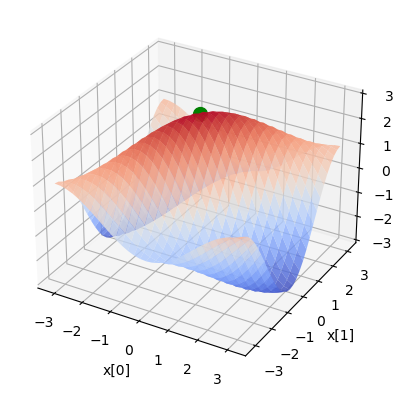

In [1]:
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pydrake.solvers import MathematicalProgram
from pydrake.solvers import IpoptSolver
import numpy as np


def constraint(x):
    return [np.cos(x[0]) + 2 * np.cos(x[0] - x[1])]

# Find a solution satisfying
# 1 <= cos(x[0]) + 2 * cos(x[0] - x[1]) <= 2
# This problem has infinitely many solutions, for example, x = [0, pi/2]

# To visualize the constraint, I draw the landscape of cos(x[0]) + 2 * cos(x[0] - x[1])), and
# also highlight the point x = [0, 0]. You could see that x = [0, 0] is at a
# peak of the landscape.
def draw_constraint_landscape():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x_mesh, y_mesh = np.meshgrid(np.linspace(-np.pi, np.pi, 31), np.linspace(-np.pi, np.pi, 31))
    constraint_val = np.cos(x_mesh) + 2 * np.cos(x_mesh - y_mesh)
    surf = ax.plot_surface(x_mesh, y_mesh, constraint_val, cmap=cm.coolwarm, alpha=0.8)
    ax.plot([0], [0], [3], marker='.', color='g', markersize=20)
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
    ax.set_zlabel("cos(x[0]) + 2 * cos(x[0]-x[1])")
    fig.show()
    

draw_constraint_landscape()

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

prog.AddConstraint(constraint, [1], [2], x)

solver = IpoptSolver()
# With the initial guess being (0, 0), the solver cannot find a solution.
prog.SetInitialGuess(x, [0, 0])
result = solver.Solve(prog)
print(f"Starting from x=[0, 0], the solver result is {result.get_solution_result()}")
print(f"The solver gets stuck at x={result.GetSolution(x)}")

# With a different initial guess, the solver can find the solution
prog.SetInitialGuess(x, [0.1, 0.5])
result = solver.Solve(prog)
print(f"Starting from x=[0.1, 0.5], the solver result is {result.get_solution_result()}")
print(f"The found solution is x={result.GetSolution(x)}")

In the example above, you could see that with a bad initial guess $x = [0, 0]$, the solver gets stuck and reports the problem being infeasible (the reason for getting stuck is that the gradient of the constraint function $cos(x[0]) + 2cos(x[0]-x[1])$ is zero at the initial guess $x=[0, 0]$, hence the gradient-based solver doesn't know how to move the decision variables. This phenomenon also appears when solving an inverse-kinematics problem with an initial pose at singularity, or solving a unit-length constraint $x^Tx=1$ with initial guess $x=0$); but by changing the initial guess, the solver can find a solution.

Note that even if the solver (like SNOPT) has found a feasible solution during the optimization process, it could jump to an infeasible value in the next iteration. SNOPT doesn't guarantee to stay within the feasible region during the optimization process.

Sometimes the problem is infeasible because the constraint is imposed incorrectly. To understand why the optimization fails, we provide some debugging tips. You could use these tips to diagonose the problematic constraint/initial guesses.

## Print a summary of the MathematicalProgram
Especially for small problems, it can be extremely helpful to display the MathematicalProgram as a string.  This will give you a list of decision variables, costs, and constraints that have been added to the program.  

In [2]:
# A sample (quadratic) program
prog = MathematicalProgram()
x = prog.NewContinuousVariables(3, "x")
prog.AddQuadraticCost(x[0] * x[0] + 2 * x[0] + 3)
prog.Add2NormSquaredCost(A = [[1, 3], [2, 4]], b=[1, 4], vars=[x[1], x[2]])
prog.AddLinearEqualityConstraint(x[0] + 2*x[1] == 5)
prog.AddLinearConstraint(x[0] + 4 *x[1] <= 10)
prog.AddBoundingBoxConstraint(-1, 10, x)
dir(x[0])
# Now print a summary:
print(prog)

Decision variables: x(0) x(1) x(2)

QuadraticCost (3 + 2 * x(0) + pow(x(0), 2))
QuadraticCost (17 - 18 * x(1) - 38 * x(2) + (x(1) * (5 * x(1) + 11 * x(2))) + (x(2) * (11 * x(1) + 25 * x(2))))
LinearConstraint
-inf <= (x(0) + 4 * x(1)) <= 10
LinearEqualityConstraint
(x(0) + 2 * x(1)) == 5
BoundingBoxConstraint
-1 <= x(0) <= 10
-1 <= x(1) <= 10
-1 <= x(2) <= 10



You can also display the program in LaTeX

In [3]:
display(Markdown(prog.ToLatex()))

\begin{align*}
\min_{x_{0}, x_{1}, x_{2}} \quad & (3 + 2x_{0} + x_{0}^{2})\\
 &  + (17 - 18x_{1} - 38x_{2} + x_{1} (5x_{1} + 11x_{2}) + x_{2} (11x_{1} + 25x_{2}))\\
 \text{subject to}\quad & (x_{0} + 4x_{1}) \le 10,\\
 & (x_{0} + 2x_{1}) = 5,\\
 & \begin{bmatrix} -1 \\ -1 \\ -1 \end{bmatrix} \le \begin{bmatrix} x_{0} \\ x_{1} \\ x_{2} \end{bmatrix} \le \begin{bmatrix} 10 \\ 10 \\ 10 \end{bmatrix}.\\
\end{align*}


## Name your costs/constraints/variables
It often helps to print out some constraints/costs for diagonosis. In order to get a meaningful print out message, you could name the costs/constraints/variables.
### 1. Name the variables
When you create the variables through `NewContinuousVariables` (or `NewBinaryVariables`), you can pass in a string as the variable name. Here is an example

In [4]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
print(x)

[Variable('point(0)', Continuous) Variable('point(1)', Continuous)]


### 2. Name the constraint
You could use `set_description()` function to name a constraint. Here is an example

In [5]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
constraint = prog.AddConstraint(lambda z: [np.sum(z**2)], [1.], [1.], x)
constraint.evaluator().set_description("unit-length constraint")
print(constraint)

PyFunctionConstraint described as 'unit-length constraint' with 2 decision variables point(0) point(1)



### 3. Name the cost
Similarly you could use `set_description()` function to name a cost. Here is an example

In [6]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
# Add the cost on the distance to (1, 2)
cost1 = prog.AddCost(lambda z: np.sqrt((z[0]-1)**2 + (z[1]-2)**2), x)
cost1.evaluator().set_description("distance to (1, 2)")
# Add the cost on the distance to (3, -1)
cost2 = prog.AddCost(lambda z: np.sqrt((z[0]-3)**2 + (z[1] + 1)**2), x)
cost2.evaluator().set_description("distance to (3, -1)")
print(f"cost1: {cost1}")
print(f"cost2: {cost2}")

cost1: PyFunctionCost described as 'distance to (1, 2)' with 2 decision variables point(0) point(1)

cost2: PyFunctionCost described as 'distance to (3, -1)' with 2 decision variables point(0) point(1)



As we will see in the next section, we can print out the infeasible constraints. By naming the variables/constraints/costs, the print out message becomes more meaningful.

## Call GetInfeasibleConstraints()
When `MathematicalProgram` is solved through a gradient-based solver (like SNOPT/IPOPT) and reports that the problem being infeasible, the solver returns the decision variable values where it gets stuck. You could call [MathematicalProgramResult::GetInfeasibleConstraints()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgramResult.GetInfeasibleConstraints) or [MathematicalProgramResult::GetInfeasibleConstraintNames()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgramResult.GetInfeasibleConstraintNames) to retrieve the constraint with large violations at that variable value. You could then diagonose the retrieved infeasible constraint and improve the constraint/initial guess accordingly.

Here is an example

In [7]:
import numpy as np
from pydrake.autodiffutils import (
    InitializeAutoDiff,
    ExtractGradient,
)
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

# Add the constraint dist(x, 0) >= 1
constraint1 = prog.AddConstraint(lambda z: [z.dot(z)], [1], [np.inf], x)
constraint1.evaluator().set_description("outside unit circle")

# Add the constraint x[0]**2 + 4 * x[1]**2 <= 4
constraint2 = prog.AddConstraint(lambda z: [z[0]**2 + 4 * z[1]**2], [0], [4], x)
constraint2.evaluator().set_description("inside ellipsoid 1")

solver = IpoptSolver()
prog.SetInitialGuess(x, [0, 0])
result = solver.Solve(prog)
print("Start from initial guess x = [0, 0]")
print(f"optimization status: {result.get_solution_result()}")
infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"infeasible constraint: {c}")
x_stuck = result.GetSolution(x)
print(f"x_stuck={x_stuck.T}")
# Now evaluate the gradient of the constraint at x_stuck (where the solver gets stuck)
print(f"Gradient of the infeasible constraint at x_stuck: {ExtractGradient(infeasible_constraints[0].evaluator().Eval(InitializeAutoDiff(x_stuck)))}")

# For a different initial state, the constraint that was infeasible now has non-zero gradient
x_new = np.array([0.1, 0.2])
print(f"\nStart from initial guess x_new = {x_new}")
print(f"Gradient of the infeasible constraint at x_new: {ExtractGradient(infeasible_constraints[0].evaluator().Eval(InitializeAutoDiff(x_new)))}")
prog.SetInitialGuess(x, x_new)
# With this new initial guess, the solver will be able to find the solution
result = solver.Solve(prog)
print(f"optimization status: {result.get_solution_result()}")

Start from initial guess x = [0, 0]
optimization status: SolutionResult.kInfeasibleConstraints
infeasible constraint: PyFunctionConstraint described as 'outside unit circle' with 2 decision variables x(0) x(1)

x_stuck=[0. 0.]
Gradient of the infeasible constraint at x_stuck: [[0. 0.]]

Start from initial guess x_new = [0.1 0.2]
Gradient of the infeasible constraint at x_new: [[0.2 0.4]]
optimization status: SolutionResult.kSolutionFound


## Enable solver verbosity
Many solvers can print out the progress in each iteration. To enable printouts, enable either [kPrintToConsole](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.CommonSolverOption) or [kPrintFileName](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.CommonSolverOption) in the [SolverOptions](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.SolverOptions).

Note that when running code in a Jupyter notebook, solvers print to the console from which the notebook is launched, rather than the notebook window. For online notebooks (e.g., Deepnote), this means that the console output will not be visible. In that case, printing to a file is better.

In [8]:
from pydrake.solvers import CommonSolverOption, SolverOptions

# Create a simple program consisting of
#  constraint: 1 <= squared_norm(x) <= 2.
#  constraint: 2 <= x[0]**2 + 4 * x[0]*x[1] + 4*x[1]**2 + 2 * x[0] <= 5.
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(lambda z: [z.dot(z)], [1], [2], x)
prog.AddConstraint(lambda z: [z[0] ** 2 + 4 * z[0] * z[1] + 4 * z[1]**2 + 2 * z[0]], [2], [5], x)
prog.SetInitialGuess(x, [0, 0])

# Solve with printing.
ipopt_solver = IpoptSolver()
filename = "/tmp/debug.txt"
solver_options = SolverOptions()
solver_options.SetOption(CommonSolverOption.kPrintFileName, filename)
result = ipopt_solver.Solve(prog, solver_options=solver_options)
with open(filename) as f:
    print(f.read())


Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   3.7006227463303134e-11    3.7006227463303134e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarit

Some solvers offer more fine-tuning for the progress output.  For example, the [IPOPT options](https://coin-or.github.io/Ipopt/OPTIONS.html) offer an IPOPT-specific `print_level` for console output or `file_print_level` for file output.

In [9]:
# Enable a slightly more verbose level of printing this time.
# The options can be attached to the program, instead of passed to Solve().
solver_options.SetOption(IpoptSolver.id(), "print_level", 5)
prog.SetSolverOptions(solver_options)
result = ipopt_solver.Solve(prog)

This is Ipopt version drake_vendor, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.00e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00

## Add Callback
Some solvers support adding a callback function, which is executed in each iteration of the optimization process. You could use this callback to visualize the progress.

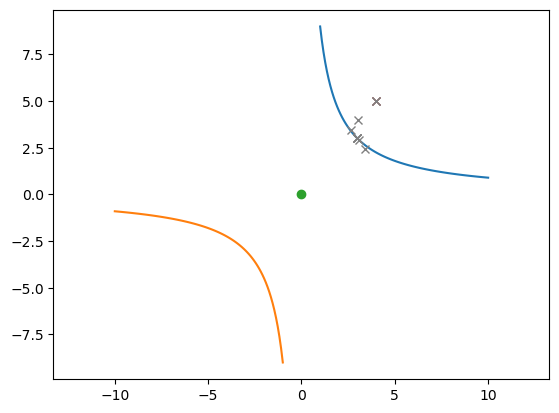

In [10]:
# Visualize the solver progress in each iteration through a callback
# Find the closest point on a curve to a desired point.
from pydrake.solvers import Solve

fig = plt.figure()
curve_x = np.linspace(1, 10, 100)
ax = plt.gca()
ax.plot(curve_x, 9./curve_x)
ax.plot(-curve_x, -9./curve_x)
ax.plot(0, 0, 'o')
x_init = [4., 5.]
ax.plot(x_init[0], x_init[1], 'x')
ax.axis('equal')

def visualization_callback(x):
    ax.plot(x[0], x[1], 'x', color='gray')
    
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] * x[1] == 9)
prog.AddCost(x[0]**2 + x[1]**2)
prog.AddVisualizationCallback(visualization_callback, x)
result = Solve(prog, x_init)

## Use EvalBinding
For each individual constraint/cost, you could call [EvalBinding(binding, x)](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgram.EvalBinding) to evaluate the constraint/cost `binding` with the program decision variables set to `x`.


In [11]:
## Demonstrate EvalBinding function
prog = MathematicalProgram()
p1 = prog.NewContinuousVariables(2, "p1")
p2 = prog.NewContinuousVariables(2, "p2")

# Add the constraint that p1 is in an ellipsoid (p1(0)-1)**2 + 4*(p1(1)-2)**2 <= 1
constraint1 = prog.AddConstraint(lambda z: [(z[0]-1)**2 + 4 * (z[1]-2)**2], [0], [1], p1)
# Add the constraint that p2 is in an ellipsoid (p2(0) + 2)**2 + 0.25*(p2(1)+ 1)**2) <= 1
constraint2 = prog.AddConstraint(lambda z: [(z[0]+2)**2 + 0.25*(z[1]+1)**2], [0], [1], p2)
# Add a cost to minimize the distance between p1 and p2
cost = prog.AddCost((p1-p2).dot(p1-p2))

# Evaluate the constraint and cost at a guess p1=[0, 1], p2 = [-1, -4]
p1_val = [0, 1]
p2_val = [-1, -4]
prog.SetInitialGuess(p1, p1_val)
prog.SetInitialGuess(p2, p2_val)
print(f"constraint 1 evaluated at p1={p1_val}, p2={p2_val} is {prog.EvalBinding(constraint1, prog.initial_guess())}")
print(f"constraint 2 evaluated at p1={p1_val}, p2={p2_val} is {prog.EvalBinding(constraint2, prog.initial_guess())}")
print(f"cost evaluated at p1={p1_val}, p2={p2_val} is {prog.EvalBinding(cost, prog.initial_guess())}")


constraint 1 evaluated at p1=[0, 1], p2=[-1, -4] is [5.]
constraint 2 evaluated at p1=[0, 1], p2=[-1, -4] is [3.25]
cost evaluated at p1=[0, 1], p2=[-1, -4] is [26.]


## Removing/relaxing constraints
When the solver reports the problem being infeasible, you could remove or relax the infeasible constraint(s), and solve the problem again. Removing the constraint is trivial, you just need to comment out the line that added the constraint in the first place. To relax the constraint bound, you can use the function [UpdateLowerBound()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.PyFunctionConstraint.UpdateLowerBound) or [UpdateUpperBound()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.PyFunctionConstraint.UpdateUpperBound). Here is a quick example

In [12]:
# Relaxing the constraint
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)

# Add the constraint x^T * x <= 1
constraint1 = prog.AddConstraint(lambda z: [z.dot(z)], [0], [1], x)
constraint1.evaluator().set_description("inside unit circle")

# Add the constraint norm(x-[3, 0]) <= 1
constraint2 = prog.AddConstraint(lambda z: [np.sum((z - np.array([3, 0]))**2)], [0], [1], x)
constraint2.evaluator().set_description("distance to [3, 0] less than 1")

prog.SetInitialGuess(x, [1, 0])
solver = IpoptSolver()
result = solver.Solve(prog)
print(f"For the original problem, the solver status is {result.get_solution_result()}")
print(f"x is stuck at {result.GetSolution(x)}")
# Now get the infeasible constraint
infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"infeasible constraint: {c}")

# Now update the upper bound of the first infeasible constraint
infeasible_constraints[0].evaluator().UpdateUpperBound([4])
# I also update the description of the constraint. Without updating the description, the
# problem still solves fine, but it would be confusing if you print out this constraint.
infeasible_constraints[0].evaluator().set_description("inside a circle with radius=2")
result = solver.Solve(prog)
print(f"For the relaxed problem, the solver status is {result.get_solution_result()}")
print(f"Solution is x = {result.GetSolution(x)}")

For the original problem, the solver status is SolutionResult.kInfeasibleConstraints
x is stuck at [1.5 0. ]
infeasible constraint: PyFunctionConstraint described as 'inside unit circle' with 2 decision variables x(0) x(1)

infeasible constraint: PyFunctionConstraint described as 'distance to [3, 0] less than 1' with 2 decision variables x(0) x(1)

For the relaxed problem, the solver status is SolutionResult.kSolutionFound
Solution is x = [2. 0.]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b4fc509-aef2-417d-a40d-6071dfed9199' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>